In [4]:
import networkx as nx
import matplotlib.pyplot as plt
import json

In [6]:
# with open("expansion.json", 'r') as file:
#     data = json.load(file)

In [12]:
# Detta gjordes för att censurera namnen i den ursprungliga datan
# for node in data['nodes']:
#     node['name'] = 'Individ %d' % node['id']

# Nätverksanalys
Nätverksanalys är ett populärt, men komplicerat verktyg för att analysera relationer hos exempelvis människor och organisationer. Ett vanligt nedladdningsbart verktyg är *Gephi* som många av er kanske stött på förut.

## Ladda in datan
Vi börjar med att ladda in datan över personer. Detta motsvarar individer som varit delaktiga Göteborgs fria scensällskap under 1900-talet (von Rosen, A. et al., 2020). Varje nod i nätverket är en individ. Eftersom flera av dessa ännu lever, har jag censurerat namnen i datan jag lagt upp till er här. 

In [16]:
with open("expansion_censored.json", 'r') as file:
    data = json.load(file)

In [20]:
data

{'nodes': [{'id': 28,
   'name': 'Individ 28',
   'gender': 'Man',
   'x': 0.6942282632610332,
   'y': -0.6527832882267909,
   'degree': 30,
   'betweenness': 0.0,
   'eigenvector': 0.00028839790811146935,
   'closeness': 0.30447499268792044},
  {'id': 30,
   'name': 'Individ 30',
   'gender': 'Kvinna',
   'x': 0.66184189652133,
   'y': -0.5943108403679189,
   'degree': 95,
   'betweenness': 0.04724064252234351,
   'eigenvector': 0.0011057835080204523,
   'closeness': 0.39431818181818185},
  {'id': 35,
   'name': 'Individ 35',
   'gender': 'Man',
   'x': 0.5529909592433636,
   'y': -0.6995743783272506,
   'degree': 36,
   'betweenness': 0.0,
   'eigenvector': 0.034975300413251115,
   'closeness': 0.321395492435937},
  {'id': 37,
   'name': 'Individ 37',
   'gender': 'Man',
   'x': 0.6435020199872924,
   'y': -0.6564940015178078,
   'degree': 12,
   'betweenness': 0.0,
   'eigenvector': 0.0029365479497005438,
   'closeness': 0.3239962651727358},
  {'id': 99,
   'name': 'Individ 99',
   

## Definiera ett nätverk
Ett nätverk har två storheter - noder och kopplingar (eller kanter). Dessa representerar exempelvis personer respektive deras relation, om det finns någon. I vårt fall har vi definierat noderna som individer i den fria teatern, och kopplingarna mellan två individer motsvarar om de någon gång varit i samma föreställning tillsammans

In [21]:
G = nx.Graph()

Vi loopar över noderna och anslutningarna i datan för att lägga till dem i grafen.

In [63]:
V = [] # V är en vanlig beteckning för noderna i ett nätverk (eng. vertex)
for node in data["nodes"]:
    
    V.append((node["id"], 
              {
               "name": node["name"], 
               "betweenness": node["betweenness"],
               "pos": (node["x"], node["y"]),
               "gender": node["gender"]
              }
             ))
    
    
E = [] # E är en vanlig beteckning för kopplingarna i ett nätverk (eng. edge)
for edge in data['edges']:
    
    E.append((edge["source"], 
              edge["target"], 
              {
                  "production": edge["prod_id"], 
                  "weight": edge["value"]}
             ))

In [64]:
G.clear()
G.add_nodes_from(V)
G.add_edges_from(E)

Alla noderna har en förberäknad position. Observera dock att positionen är i slutändan godtycklig, och man väljer oftast en visualisering som passar ens egen syften.

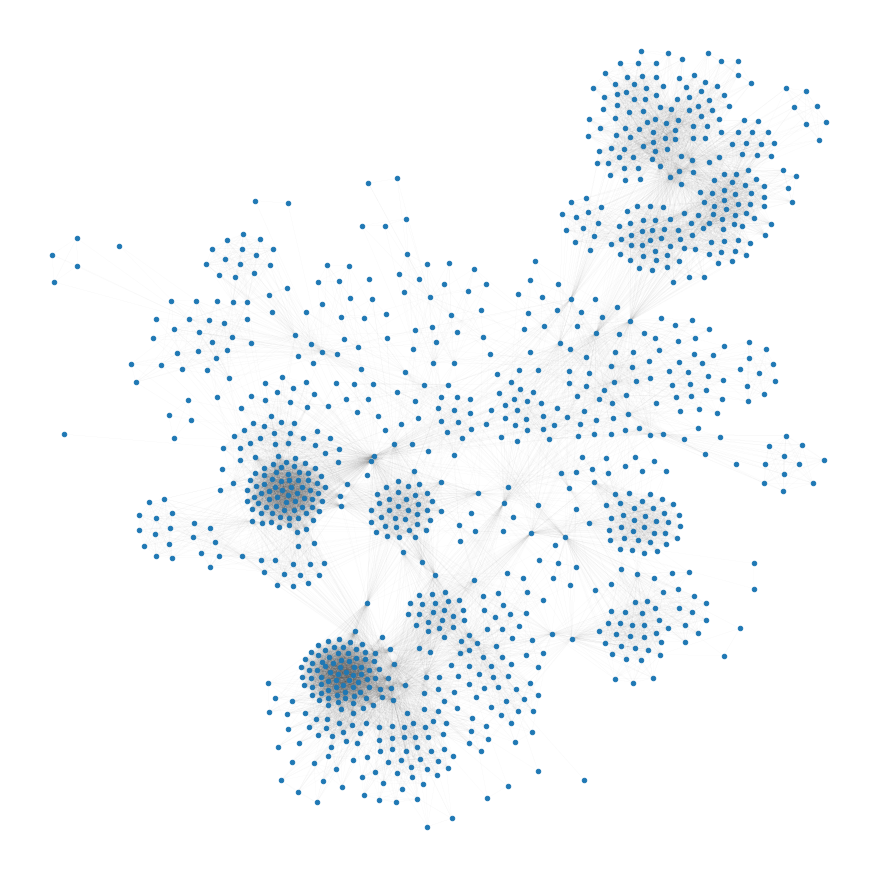

In [51]:
plt.figure(3,figsize=(12, 12)) 


options = {'width': 0.01,
           'node_size': 20,
           'pos': nx.get_node_attributes(G,'pos'),
#            'node_color': list(nx.get_node_attributes(G, 'betweenness').values()), 
           'cmap':plt.cm.copper
          }

nx.draw(G, **options)

## Interaktiv visualisering
Medan det är häftigt att kunna se denna visualiseringen, så är en viktig del av nätverksanalys att nätverket är någorlunda interaktivt och går att interagera med. Vi använder därför ett bibliotek vid namn *Bokeh*.

In [62]:
from bokeh.io import output_file, show, output_notebook
from bokeh.models import (BoxZoomTool, Circle, HoverTool,
                          MultiLine, Plot, Range1d, ResetTool, 
                          TapTool, NodesAndLinkedEdges, EdgesAndLinkedNodes
                         )
from bokeh.palettes import Spectral4
from bokeh.models.graphs import from_networkx
from bokeh.transform import linear_cmap, log_cmap

edge_attrs = {}

# Show with Bokeh
plot = Plot(plot_width=900, plot_height=900,
            x_range=Range1d(-1.1, 1.1), y_range=Range1d(-1.1, 1.1))

plot.title.text = "Graph Interaction Demonstration"

node_hover_tool = HoverTool(tooltips=[("index", "@index"), ("name", "@name")])
plot.add_tools(node_hover_tool, BoxZoomTool(), ResetTool(), TapTool())

graph_renderer = from_networkx(G, nx.spring_layout, pos=nx.get_node_attributes(G,'pos'), scale=1, center=(0, 0))


# graph_renderer.node_renderer.glyph = Circle(size=10, fill_alpha=0.3, fill_color=Spectral4[0])

betweenness = [value+1e-7 for value in nx.get_node_attributes(G, 'betweenness').values()]

graph_renderer.node_renderer.glyph = Circle(
    size=5, 
    fill_alpha=1,
    fill_color=log_cmap('betweenness', 'RdYlBu4', min(betweenness), max(betweenness))
)

graph_renderer.node_renderer.selection_glyph = Circle(size=5, fill_color=Spectral4[2])
graph_renderer.node_renderer.hover_glyph = Circle(size=5, fill_color=Spectral4[1])

graph_renderer.edge_renderer.glyph = MultiLine(line_color="#CCCCCC", line_alpha=0.3, line_width=1)
graph_renderer.edge_renderer.selection_glyph = MultiLine(line_color=Spectral4[2], line_width=1.5)
graph_renderer.edge_renderer.hover_glyph = MultiLine(line_color=Spectral4[1], line_width=1)

graph_renderer.selection_policy = NodesAndLinkedEdges()
# graph_renderer.inspection_policy = EdgesAndLinkedNodes()

plot.renderers.append(graph_renderer)

output_notebook()
show(plot)


Loading BokehJS ...

## Mer än bara visualisering
Visualiseringen av nätverk är ett kraftfullt verktyg för att få översikt av väldigt mycket data. Den utgör dock i sig inte en kvantitativ analys.

Istället kan man titta på en hel del intressanta värden som kommer av nätverksanalysen. Den viktigaste av dessa är troligen olika former av centralitet.

Centralitet är en samling matematiska begrepp som beskriver hur *centrala* noder är i ett nätverk. Ett av de vanligaste är 
- **Gradcentralitet**: Hur många kontakter har varje individ?
- **Betweenness**: Vilket är det minsta antalet kontakter man måste gå via för att ta sig till en viss individ?
- **Egenvektorscentralitet**: Om man börjar på vilken individ som helst och går via kontakterna, vilka individer är mest sannolika att man hamnar hos?

Vi betraktar en enkel hypotes: Män är mer centrala (i betweenness) än vad kvinnor är. 

In [84]:
deg_by_sex = {'Man': [], 'Kvinna': [], 'Okänt': [], 'Unknown': []}
bet_by_sex = {'Man': [], 'Kvinna': [], 'Okänt': [], 'Unknown': []}
n_by_sex = {'Man': 0, 'Kvinna': 0, 'Okänt': 0, 'Unknown': 0}


gender = nx.get_node_attributes(G, 'gender')
betweenness = nx.get_node_attributes(G, 'betweenness')
degrees = nx.degree_centrality(G)
for node_id in G.nodes:

    bet_by_sex[gender[node_id]].append(betweenness[node_id])
#     deg_by_sex[gender[node_id]].append(degrees[node_id])
    deg_by_sex[gender[node_id]].append(G.degree()[node_id])

    n_by_sex[gender[node_id]] += 1

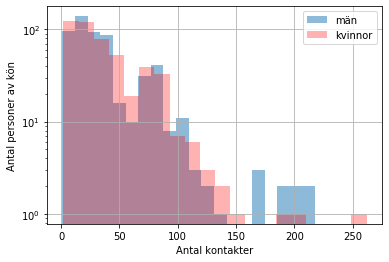

In [99]:
plt.grid()
plt.hist(deg_by_sex['Man'], alpha=0.5, label='män', bins=20)
plt.hist(deg_by_sex['Kvinna'], alpha=0.3, label='kvinnor', bins=20, color='red')
plt.ylabel('Antal personer av kön')
plt.xlabel('Antal kontakter')
plt.yscale('log', nonposy='clip')
plt.legend()

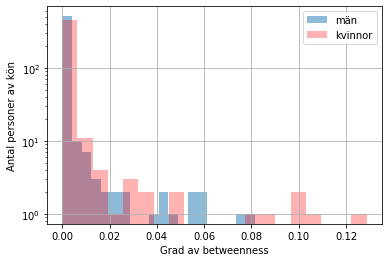

In [100]:
plt.grid()
plt.hist(bet_by_sex['Man'], alpha=0.5, label='män', bins=20)
plt.hist(bet_by_sex['Kvinna'], alpha=0.3, label='kvinnor', bins=20, color='red')
plt.ylabel('Antal personer av kön')
plt.xlabel('Grad av betweenness')
plt.yscale('log', nonposy='clip')
plt.legend()